In [10]:
%autosave 0
from __future__ import print_function

Autosave disabled


# Clustering RNA structures

We start by clustering the structures obtained from the previous example "example_08_snippet.ipynb", where we extracted all fragments with sequence GNRA from the PDB of the large ribosomal subunit. 

First, we calculate the g-vectors for all PDB files


In [11]:
import glob
import barnaba as bb
import numpy as np

flist = glob.glob("snippet/*.pdb")
if(len(flist)==0):
    print("# You need to run the example example8_snippet.ipynb")
    exit()
    
# calculate G-VECTORS  for all files
gvecs = []
for f in flist:
    gvec,seq = bb.dump_gvec(f)
    assert len(seq)==4
    gvecs.extend(gvec)



# Loading snippet/1S72_100_G_9_0_00146.pdb 
# Loading snippet/1S72_101_G_9_0_00147.pdb 
# Loading snippet/1S72_102_G_9_0_00148.pdb 
# Loading snippet/1S72_1037_G_0_0_00055.pdb 
# Loading snippet/1S72_1055_G_0_0_00056.pdb 
# Loading snippet/1S72_1075_G_0_0_00057.pdb 
# Loading snippet/1S72_1076_G_0_0_00058.pdb 
# Loading snippet/1S72_1087_G_0_0_00059.pdb 
# Loading snippet/1S72_1121_G_0_0_00060.pdb 
# Loading snippet/1S72_1158_G_0_0_00061.pdb 
# Loading snippet/1S72_1163_G_0_0_00062.pdb 
# Loading snippet/1S72_116_G_0_0_00003.pdb 
# Loading snippet/1S72_1190_G_0_0_00063.pdb 
# Loading snippet/1S72_1197_G_0_0_00064.pdb 
# Loading snippet/1S72_1239_G_0_0_00065.pdb 
# Loading snippet/1S72_1258_G_0_0_00066.pdb 
# Loading snippet/1S72_1284_G_0_0_00067.pdb 
# Loading snippet/1S72_1315_G_0_0_00068.pdb 
# Loading snippet/1S72_1325_G_0_0_00069.pdb 
# Loading snippet/1S72_1327_G_0_0_00070.pdb 
# Loading snippet/1S72_1349_G_0_0_00071.pdb 
# Loading snippet/1S72_1354_G_0_0_00072.pdb 
# Loading snip

Then, we reshape the array so that has the dimension $(N,n \ast 4\ast 4)$, where N is the number of frames and n is the number of nucleotides 

In [12]:
gvecs = np.array(gvecs)
gvecs = gvecs.reshape(149,-1)
print(gvecs.shape)


(149, 64)


C. We project the data using a simple principal component analysis on the g-vectors


In [13]:
import barnaba.cluster as cc
# calculate PCA
v,w = cc.pca(gvecs,nevecs=3)
print("# Cumulative explained variance of component: 1=%5.1f 2:=%5.1f 3=%5.1f" % (v[0]*100,v[1]*100,v[2]*100))

# Cumulative explained variance of component: 1= 26.6 2:= 48.7 3= 64.9


Text(0,0.5,'PC2')

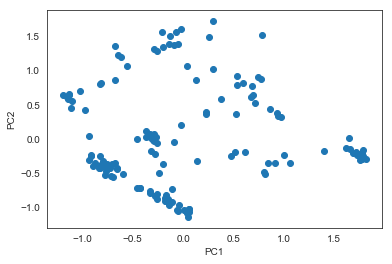

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

plt.scatter(w[:,0],w[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")

D. We make use of DBSCAN in sklearn to perform clustering. The function cc.dbscan takes four arguments:  
    i. the list of G-vectors gvec  
    ii. the list of labels for each point  
    iii. the eps value
    iv. min_samples 
    v. (optional) the weight of the samples for non-uniform clustering

The function outputs some information on the clustering: the number of clusters, the number of samples assigned to clusters (non noise), and silouetthe.

For each cluster it reports the size, the  maximum eRMSD distance between samples in a cluster (IC=intra-cluster), the median  intra-cluster eRMSD, the maximum and median distance from the centroid.  

In [15]:
new_labels, center_idx = cc.dbscan(gvecs,range(gvecs.shape[0]),eps=0.35,min_samples=8)


# eps:0.700 min_samples:8  nclusters: 4
#  silhouette score: 0.1728
# Avg silhouette: 0.6111 
# assigned samples :71 total samples:149 
#  N size       max eRMSD (IC)       med eRMSD (IC) max eRMSD (centroid) med eRMSD (centroid) center 
# 00 0026                0.613                0.309                0.440                0.222 00 118
# 01 0022                0.553                0.337                0.372                0.280 01 11
# 02 0015                0.543                0.286                0.370                0.229 02 4
# 03 0008                0.453                0.228                0.311                0.158 03 8


We can now color the PCA according to the different cluster and display the centroid as a label:


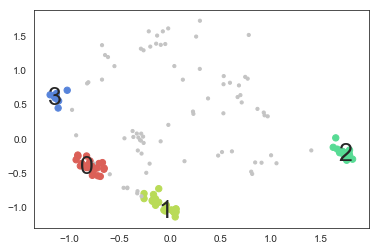

In [16]:
cp = sns.color_palette("hls",len(center_idx)+1)
colors = [cp[j-1] if(j!=0) else (0.77,0.77,0.77) for j in new_labels]
size = [40 if(j!=0) else 10 for j in new_labels]
#do scatterplot
plt.scatter(w[:,0],w[:,1],s=size,c=colors)
for i,k in enumerate(center_idx):
    plt.text(w[k,0],w[k,1],str(i),ha='center',va='center',fontsize=25)

E. We finally visualise the 4 centroids:

In [17]:
import py3Dmol

cluster_0 = open(flist[center_idx[0]],'r').read()
cluster_1 = open(flist[center_idx[1]],'r').read()
cluster_2 = open(flist[center_idx[2]],'r').read()
cluster_3 = open(flist[center_idx[3]],'r').read()

p = py3Dmol.view(width=900,height=600,viewergrid=(2,2))
#p = py3Dmol.view(width=900,height=600)
#p.addModel(query_s,'pdb')
p.addModel(cluster_0,'pdb',viewer=(0,0))
p.addModel(cluster_1,'pdb',viewer=(0,1))
p.addModel(cluster_2,'pdb',viewer=(1,0))
p.addModel(cluster_3,'pdb',viewer=(1,1))


#p.addModel(hit_0,'pdb',viewer=(0,1))
p.setStyle({'stick':{}})
p.setBackgroundColor('0xeeeeee')
p.zoomTo()
p.show()

It is interesting to observe that cluster 0 and 1 (in close proximity in the PCA projection), correspond to A-form-like structures. Cluster 2 corresponds to the classic GNRA fold. 